![header](../figures/logos_partenaires._cmems_se.jpg)

# Read and download regional data

<div style="text-align: right"><i> 2023-04-27 READ_AND_DOWNLOAD_REGIONAL_DATA </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Read and download regional data</center></h1>
<h5> The notebook illustrates how to read online the global data, select the regional data of interest and locally save them in a netcdf file. The example is given here for the Gulf Stream region (see DC_2020 and DC_2021 data challenges). </h5>   
     
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know how you can :
<ul>
  <li>read online the global data,</li>
  <li>select the regional data of interest,</li>
  <li>locally save them in a netcdf file.</li>
</ul>
    

</div>

In [1]:
from glob import glob
import numpy as np
import os

In [2]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_read import *
from src.mod_spectral import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>Experiment setup</h2>

</div>

In [4]:
# Example for Gulf Stream region
lon_min = 295                                          # domain min longitude
lon_max = 305                                          # domain max longitude
lat_min = 33.                                          # domain min latitude
lat_max = 43.                                          # domain max latitude

# Time slice if you are interested in a shorter evaluation period
time_min = '2019-01-01'                                # time min for analysis
time_max = '2019-12-31'                                # time max for analysis

# Saving directory and outputs
saving_dir = '../data/'                                # saving directory path   
name_maps = 'DUACS_GS.nc'                              # regional maps file name
name_alg = 'indep_nadir_GS.nc'                         # regional independant nadir file name

<div class="alert alert-info" role="alert">

<h2>Read online global data, select region and locally save file </h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [5]:
%%time
path_catalog = "https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/catalog/meomopendap/extract/ocean-data-challenges/dc_Map_global_OSE/independent_alongtrack/alg/2019/catalog.html" 
path_data =    "https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/dc_Map_global_OSE/independent_alongtrack/alg/2019/"

     
list_of_files = retrieve_list_of_files_from_url(path_catalog, path_data)

xr.set_options(file_cache_maxsize=12)
ds_alg = xr.open_mfdataset(sorted(list_of_files)[:],chunks={'time':47151},concat_dim='time',combine='nested')
ds_alg = ds_alg.where((ds_alg.time >= np.datetime64(time_min)) & (ds_alg.time <=  np.datetime64(time_max)), drop=True)
ds_alg = ds_alg.sortby('time')
lon=np.array(ds_alg.longitude.values)
lat=np.array(ds_alg.latitude.values)
ind_lonmax = lon<lon_max 
ind_lonmin = lon>lon_min 
ind_latmax = lat<lat_max 
ind_latmin = lat>lat_min 
ind_sel_time = (ind_lonmax*ind_lonmin*ind_latmax*ind_latmin)
ds_alg = ds_alg.isel({'time':ind_sel_time})
ds_alg.to_netcdf(saving_dir+name_alg)


CPU times: user 5min 3s, sys: 38.9 s, total: 5min 42s
Wall time: 10min 5s


## DUACS maps

In [6]:
%%time
path_catalog = "https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/catalog/meomopendap/extract/ocean-data-challenges/dc_Map_global_OSE/maps/DUACS_global_allsat-alg/catalog.html" 
path_data =    "https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/dc_Map_global_OSE/maps/DUACS_global_allsat-alg/"

     
list_of_files = retrieve_list_of_files_from_url(path_catalog, path_data)

xr.set_options(file_cache_maxsize=12)
ds_maps = xr.open_mfdataset(sorted(list_of_files)[:],chunks={'time':1,'latitude':720,'longitude':1440},concat_dim='time',combine='nested')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))

# We select the region size 0.5° wider on each side to avoid interpolation issues later

ds_maps = ds_maps.sel({'longitude':slice(lon_min-0.5,lon_max+0.5)})
ds_maps = ds_maps.sel({'latitude':slice(lat_min-0.5,lat_max+0.5)})
ds_maps.to_netcdf(saving_dir+name_maps)

CPU times: user 1min 30s, sys: 11.7 s, total: 1min 42s
Wall time: 3min 24s


### You can now use the evaluation notebooks by changing the data directory and file names !

In [7]:
%%time 
ds_alg=xr.open_dataset('../data_dev/indep_nadir_GS.nc')  
ds_maps=xr.open_dataset('../data_dev/DUACS_GS.nc')

CPU times: user 130 ms, sys: 491 ms, total: 621 ms
Wall time: 800 ms


In [8]:
%%time 
ds_interp = run_interpolation(ds_maps, ds_alg)
#ds_interp = ds_interp.dropna('time')
ds_interp

2023-06-27 15:09:05 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-06-30 00:00:00 to 2019-08-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-07-31 00:00:00 to 2019-09-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-08-31 00:00:00 to 2019-10-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-09-30 00:00:00 to 2019-11-01 00:00:00
2023-06-27 15:09:05 INFO     fetch data from 2019-10-31 00:00:00 to 2019-12-01 00:00:00
2023-06-27 15:09:05 INFO     fet

CPU times: user 318 ms, sys: 45.2 ms, total: 363 ms
Wall time: 485 ms


<xarray.Dataset>
Dimensions:            (time: 37177)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-01T22:10:01.073445888 .....
Data variables: (12/13)
    cycle              (time) float64 126.0 126.0 126.0 ... 136.0 136.0 136.0
    track              (time) float64 36.0 36.0 36.0 36.0 ... 391.0 391.0 391.0
    sla_unfiltered     (time) float32 0.124 0.177 0.163 ... 0.152 0.181 0.176
    sla_filtered       (time) float32 0.151 0.161 0.166 ... 0.151 0.169 0.178
    dac                (time) float32 0.058 0.059 0.059 ... -0.059 -0.059 -0.06
    ocean_tide         (time) float32 0.172 0.172 0.173 ... -0.339 -0.342 -0.349
    ...                 ...
    lwe                (time) float32 -0.044 -0.043 -0.043 ... -0.047 -0.047
    mdt                (time) float32 -0.174 -0.172 -0.17 ... -0.173 -0.17
    tpa_correction     (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 305.0 304.9 304.9 ... 297.6 297.6 297.6
    latitude           (time) float64 42.99 42.93 42.87 ... 42.86 42.92 42.98
    msla_interpolated  (time) float64 0.1328 0.1322 0.1284 ... 0.106 0.1141

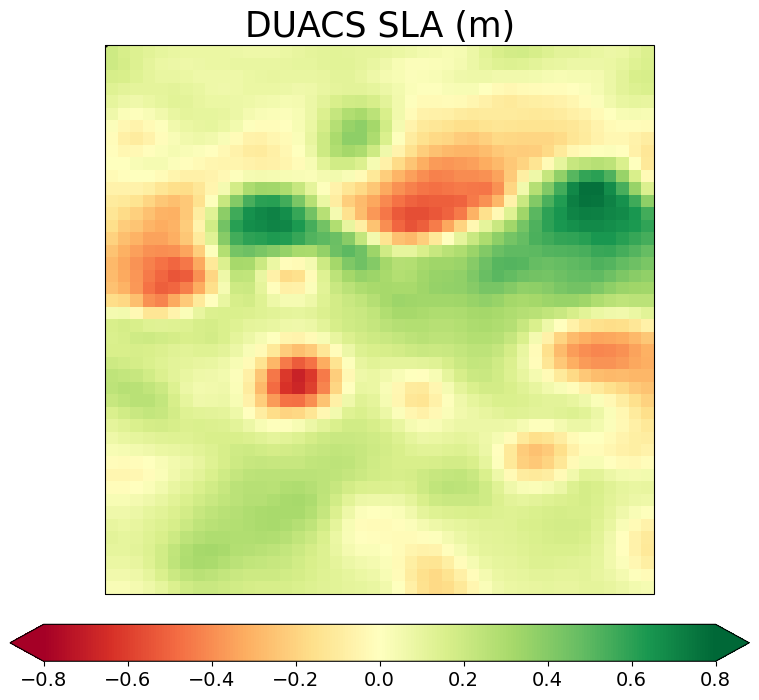

In [9]:
fig= plt.figure(figsize=(14, 8))
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.title('DUACS SLA (m)',fontsize=25)
lon,lat=np.meshgrid(ds_maps.longitude,ds_maps.latitude)
plt.pcolormesh(lon,lat,ds_maps.sla.values[0,:,:],cmap='RdYlGn',vmin=-0.8,vmax=0.8)
cbar = plt.colorbar(extend='both',fraction=0.06, orientation="horizontal", pad=0.05)
cbar.ax.tick_params(labelsize=14)
ax.add_feature(cfeature.LAND, zorder=2)
ax.coastlines(zorder=2)
plt.show()

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [7]:
%%time
ds_interp = run_interpolation(ds_maps, ds_alg)
ds_interp = ds_interp.dropna('time')
ds_interp

NameError: name 'ds_maps' is not defined

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the maps have been interpolated to the position of the along-track, it is possible to calculate different statistics on the time series SLA_alongtrack and SLA_maps. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps, temporal evolution of global error variance and explained variance. 

These statistics are also applied to the filtered signals focusing on the 65-500km scale range. A bandpass filter is applied before calculating the scores.  

In [11]:

output_dir = '../results_dev'                                      # output directory path
os.system(f'mkdir -p {output_dir}')
stat_output_filename = f'{output_dir}/stat_sla_duacs_geos.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_sla_duacs_geos.nc'    # output spectral analysis filename
segment_lenght = 1000.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis


In [12]:
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename, method_name='DUACS')

2023-06-27 15:09:41 INFO     Compute mapping error all scales
2023-06-27 15:09:41 INFO     Compute mapping error for scales between 65.0 and 500.0 km
2023-06-27 15:09:43 INFO     Compute binning statistics
2023-06-27 15:09:44 INFO     Compute statistics by oceanic regime
2023-06-27 15:10:03 INFO     Stat file saved as: ../results_dev/stat_sla_duacs_geos.nc


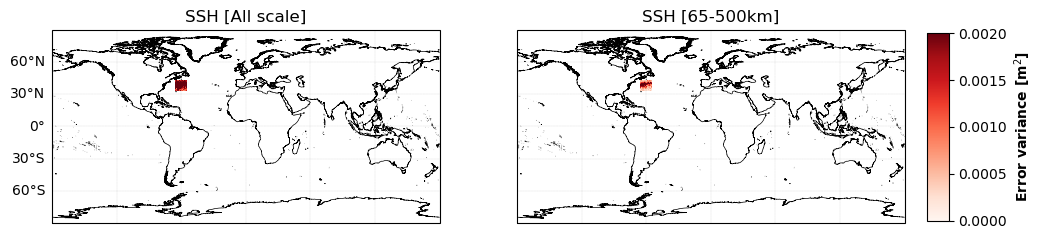

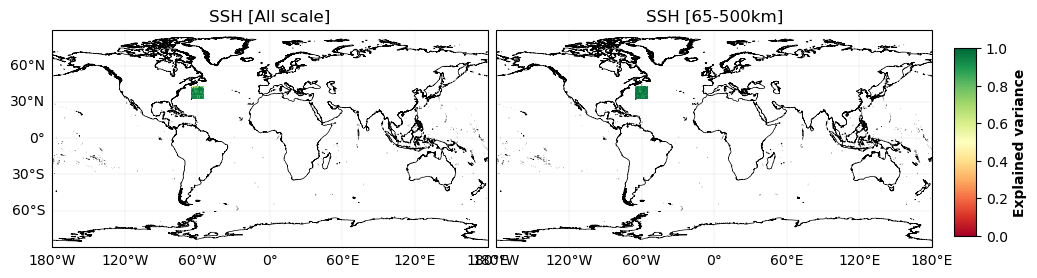

In [13]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map(stat_output_filename)
# Matplotlib
plot_stat_score_map_png(stat_output_filename)

In [14]:
plot_stat_score_timeseries(stat_output_filename)

:Layout
   .Overlay.I  :Overlay
      .Curve.All_scale :Curve   [time]   (timeserie_variance_mapping_err)
      .Curve.Filtered  :Curve   [time]   (timeserie_variance_mapping_err)
   .Overlay.II :Overlay
      .Curve.All_scale :Curve   [time]   (explained_variance_score)
      .Curve.Filtered  :Curve   [time]   (explained_variance_score)

In [15]:
plot_stat_by_regimes(stat_output_filename)

,mapping_err_var [m²],sla_unfiltered_var [m²],mapping_err_filtered_var [m²],sla_filtered_var [m²],var_score_allscale,var_score_filtered
coastal,0.001673,0.012362,0.000499,0.008289,0.864663,0.939805
offshore_highvar,0.004331,0.075310,0.001381,0.032796,0.942486,0.957888
offshore_lowvar,0.001736,0.017152,0.000536,0.010270,0.898770,0.947849
equatorial_band,NaN,NaN,NaN,NaN,NaN,NaN
arctic,NaN,NaN,NaN,NaN,NaN,NaN
antarctic,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3 Compute Spectral scores

In [ ]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght)

In [ ]:
# Plot effective resolution
# Hvplot
# plot_effective_resolution(psd_output_filename)
# Matplotlib
plot_effective_resolution_png(psd_output_filename)

In [ ]:
plot_psd_scores(psd_output_filename)

The interactive plot above allows you to explore the spectral metrics by latitude / longitude box